# 1. Titanic Prediction

## 1.1 Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## 1.2 Load Dataset

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.3 Inspecting of the data
Data inspecting is the process for review and identify errors, inconsistencies, and patterns

In [3]:
print("\nColumn information:")
print(train_data.info())

print("\nMissing values:")
print(train_data.isnull().sum())

print("\nBasic statistics:")
print(train_data.describe())


Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin      

### 1.4 Find Unique Column
Find and clear column that have unique value. It can clear our data and unique column is unnecesarry

In [4]:
# Clear column where have Nan
unique_column = []
for col in train_data.columns:
    if train_data[col].nunique() == train_data.shape[0]:
        unique_column.append(col)
        print(f"{col}: {train_data[col].nunique()} unique values")

PassengerId: 891 unique values
Name: 891 unique values


### 1.5 Data Preprocessing

In [19]:
# Make copies for preprocessing
train_df = train_data.copy()
test_df = test_data.copy()

# Drop columns that are not useful for prediction
# PassengerId and Name are unique identifiers, Ticket has too many unique values
columns_to_drop = ['PassengerId', 'Name', 'Ticket']
train_df = train_df.drop(columns_to_drop, axis=1)

# Handle missing values
print("Missing values before preprocessing:")
print(train_df.isnull().sum())

# Age: Fill with median age
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

# Embarked: Fill with mode (most common)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# Cabin has too many missing values, let's create a binary feature
train_df['Has_Cabin'] = train_df['Cabin'].notna().astype(int)
train_df = train_df.drop('Cabin', axis=1)

print("\nMissing values after preprocessing:")
print(train_df.isnull().sum())

Missing values before preprocessing:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Missing values after preprocessing:
Survived     0
Pclass       0
Sex          0
Age          0
SibSp        0
Parch        0
Fare         0
Embarked     0
Has_Cabin    0
dtype: int64


#### 1.6 Create new features to make easier model for train data

In [20]:
# Create family size feature
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Create binary feature for traveling alone
train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)

# Extract title from name (using original data)
train_df['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify titles
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Col': 'Rare',
    'Major': 'Rare',
    'Mlle': 'Miss',
    'Countess': 'Rare',
    'Ms': 'Miss',
    'Lady': 'Rare',
    'Jonkheer': 'Rare',
    'Don': 'Rare',
    'Dona': 'Rare',
    'Mme': 'Mrs',
    'Capt': 'Rare',
    'Sir': 'Rare'
}
train_df['Title'] = train_df['Title'].map(title_mapping)
train_df['Title'].fillna('Rare', inplace=True)



print("New features created:")
print("- FamilySize")
print("- IsAlone") 
print("- Has_Cabin")
print("- Title")

New features created:
- FamilySize
- IsAlone
- Has_Cabin
- Title


### 1.7 Encode data
Data with categorical column to easier model to train data

In [21]:
# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['Sex', 'Embarked', 'Title']

for col in categorical_cols:
    train_df[col] = le.fit_transform(train_df[col])

print(f"\nEncoded categorical columns: {categorical_cols}")

# Prepare features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 
           'FamilySize', 'IsAlone', 'Has_Cabin', 'Title']

# Check if all features exist and have no missing values
print("\nFinal feature check:")
for feature in features:
    if feature in train_df.columns:
        missing_count = train_df[feature].isnull().sum()
        print(f"{feature}: {missing_count} missing values")
    else:
        print(f"ERROR: {feature} not found in dataset")

# Remove any remaining rows with missing values in selected features
initial_shape = train_df.shape[0]
train_df = train_df.dropna(subset=features)
final_shape = train_df.shape[0]
print(f"\nRows removed due to missing values: {initial_shape - final_shape}")

X = train_df[features]
y = train_df['Survived']

print(f"\nFinal dataset shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())


Encoded categorical columns: ['Sex', 'Embarked', 'Title']

Final feature check:
Pclass: 0 missing values
Sex: 0 missing values
Age: 0 missing values
SibSp: 0 missing values
Parch: 0 missing values
Fare: 0 missing values
Embarked: 0 missing values
FamilySize: 0 missing values
IsAlone: 0 missing values
Has_Cabin: 0 missing values
Title: 0 missing values

Rows removed due to missing values: 0

Final dataset shape: (891, 11)
Target distribution:
Survived
0    549
1    342
Name: count, dtype: int64


### 1.8 Splitting Data
Split data for 20% for testing and 80% for train model

In [22]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")


Training set: (712, 11)
Validation set: (179, 11)


### 1.9 Use Random Forest and Logistic Regression model

In [25]:
print("MODEL TRAINING")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_val)
lr_pred = lr_model.predict(X_val)


MODEL TRAINING


## 1.10 Evaluate model
Understand the model which column important for the model

In [27]:
# Evaluate models
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_val, rf_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_val, rf_pred)}")

print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_val, lr_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_val, lr_pred)}")

# Feature importance (Random Forest)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)

Random Forest Results:
Accuracy: 0.7989
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       110
           1       0.73      0.75      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179


Logistic Regression Results:
Accuracy: 0.8156
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179


Feature Importance (Random Forest):
       feature  importance
5         Fare    0.228344
2          Age    0.206490
1          Sex    0.173129
10       Title    0.131856
0       Pclass    0.063351
9    Has_Cabin

# 2. Analysis of the data

In [47]:
print("CREATING VISUALIZATIONS")
print("="*50)

CREATING VISUALIZATIONS


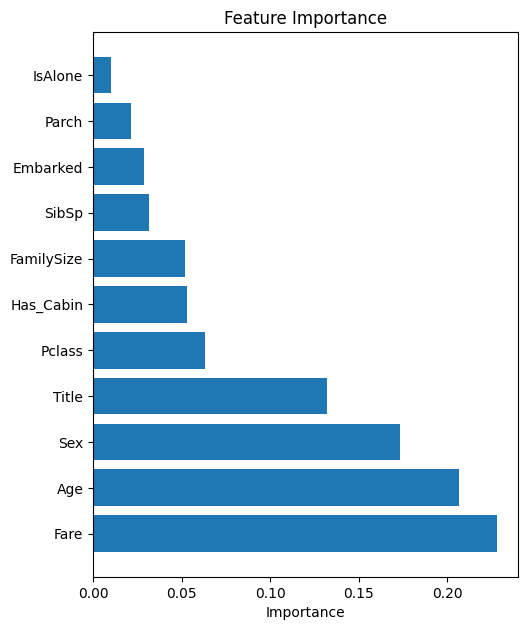

In [39]:
# Feature importance
plt.figure(figsize=(15, 12))
plt.subplot(2, 3, 5)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Feature Importance (from a model, likely Random Forest or another tree-based method)
The most important features: Fare, Age, Sex, and Title. Less important: IsAlone, Parch.
This means ticket price (proxy for socio-economic status), age, gender, and honorific titles are key determinants of survival.

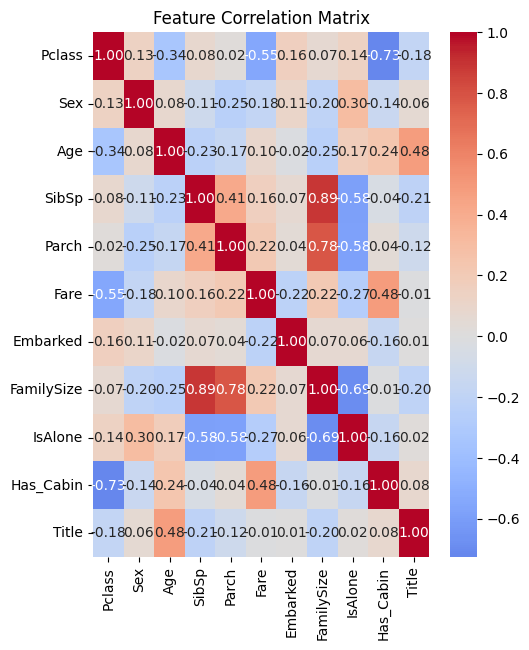

In [46]:
# Correlation matrix
plt.figure(figsize=(15, 12))
plt.subplot(2, 3, 6)
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Strong negative correlation between Pclass and Fare (-0.55), which makes sense (higher class → higher fare).

FamilySize is strongly correlated with SibSp (0.78) and Parch (0.78) since it’s derived from them.

IsAlone is negatively correlated with FamilySize (-0.69).

Most other correlations are low → meaning no severe multicollinearity, so these features can be used together in a model.

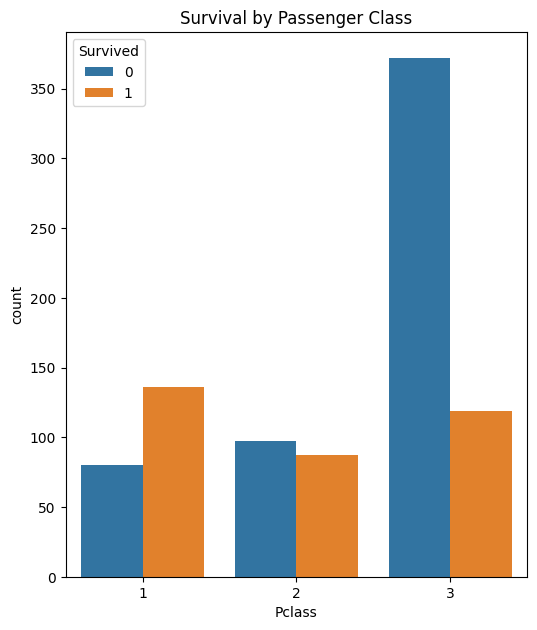

In [41]:
# Survival rate by class
plt.figure(figsize=(15, 12))
plt.subplot(2, 3, 1)
sns.countplot(data=train_data, x='Pclass', hue='Survived')
plt.title('Survival by Passenger Class')
plt.tight_layout()
plt.show()

First-class passengers had the highest survival rate (more orange than blue).

Third-class passengers had the lowest survival rate (blue dominates).
Socio-economic status (ticket class) strongly influenced survival chances.

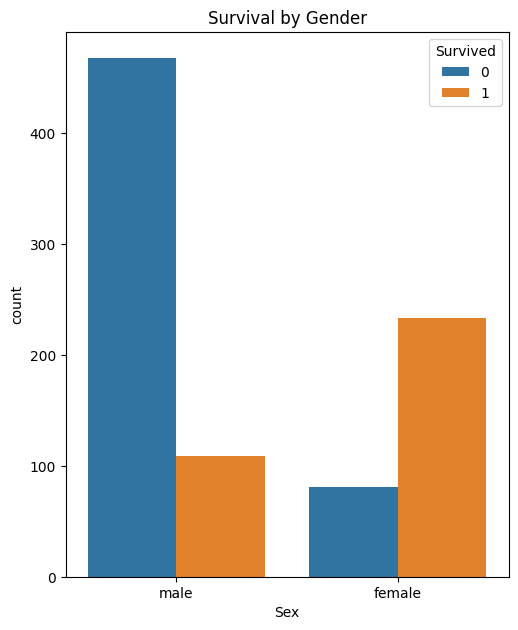

In [42]:
# Survival rate by sex
plt.figure(figsize=(15,12))
plt.subplot(2, 3, 2)
sns.countplot(data=train_data, x='Sex', hue='Survived')
plt.title('Survival by Gender')
plt.tight_layout()
plt.show()

Females had a much higher survival rate than males.

Most men did not survive (blue is much higher).
This reflects the evacuation rule: “women and children first.”

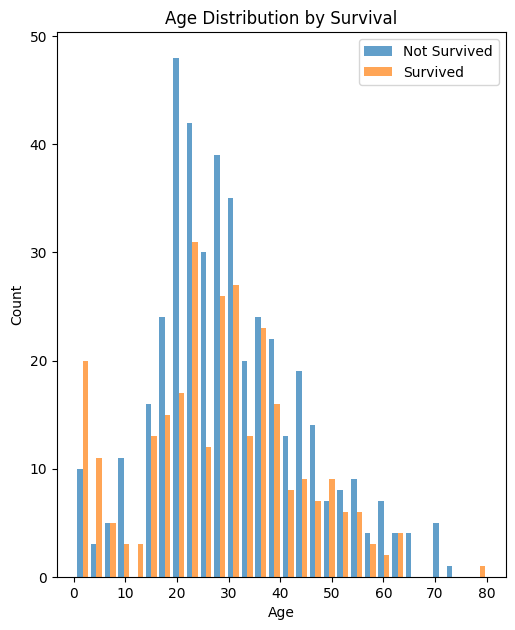

In [43]:
# Age distribution
plt.figure(figsize=(15,12))
plt.subplot(2, 3, 3)
plt.hist([train_data[train_data['Survived']==0]['Age'].dropna(), 
          train_data[train_data['Survived']==1]['Age'].dropna()], 
         bins=30, alpha=0.7, label=['Not Survived', 'Survived'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Survival')
plt.legend()
plt.tight_layout()
plt.show()

Children (under 10 years old) were more likely to survive (orange dominates blue in that range).

Young adults (20–40 years old) had higher death rates (more blue).

Elderly passengers (>60 years old) were fewer in number but most did not survive.
Youth increased survival chances, but overall survival was still dominated by women and first-class passengers.

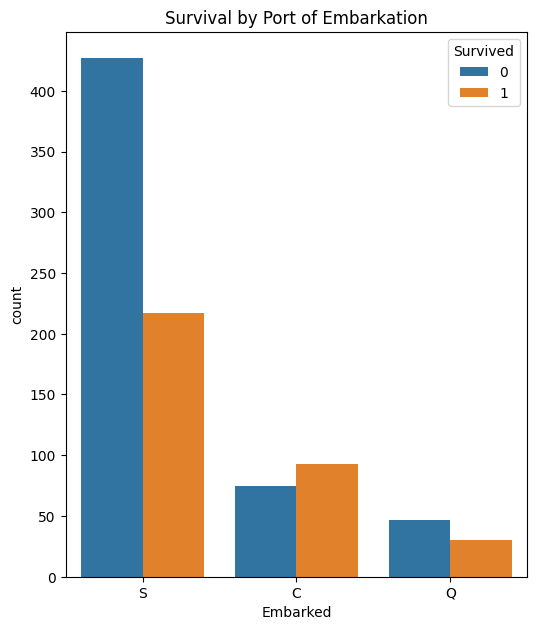

In [45]:
# Survival rate by embarked
plt.figure(figsize=(15,12))
plt.subplot(2, 3, 4)
sns.countplot(data=train_data, x='Embarked', hue='Survived')
plt.title('Survival by Port of Embarkation')
plt.tight_layout()
plt.show()

Most passengers boarded at S (Southampton).

Survival rate (orange) was higher for passengers from C (Cherbourg) compared to S and Q.

This likely reflects differences in ticket class and social status of passengers boarding at each port.